In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pip Install

In [2]:
!pip install --upgrade scikit-learn scikeras

!pip install soundfile --upgrade

!pip install bayesian-optimization

!pip install scikeras

!pip install audiomentations

!pip install librosa matplotlib numpy

!pip install torchaudio librosa matplotlib numpy

!pip install librosa pydub numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 36.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: soxr
    Found existing installation: soxr 1.0.0
    Uninstalling soxr-1.0.0:
      Successfully uninstalled soxr-1.0.0


### Import Library

In [3]:
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import librosa.display
import librosa
import os as os
import tensorflow as tf
import seaborn as sns
import random
import keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from pydub import AudioSegment
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


In [4]:
path = '/content/drive/MyDrive/Voice_Skripsi_fix'

# Pre-processing

#### Normalisasi

In [5]:
def normalize_audio(file_path, output_path):
    try:
        audio = AudioSegment.from_file(file_path)
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return

    # Normalisasi volume
    normalized_audio = audio.apply_gain(-audio.dBFS)

    # Menyimpan audio yang sudah dinormalisasi
    normalized_audio.export(output_path, format="wav")
    print(f"Audio telah dinormalisasi dan disimpan di: {output_path}")

#### Pembersihan data

In [6]:
def clean_audio(file_path, target_sr=22050, min_duration=1.0):
    try:
        # Baca file audio
        audio_data, sample_rate = sf.read('conten/drive/MyDrive/Voice_Skripsi_fix')

        # Cek audio kosong
        if audio_data.size == 0:
            print(f"⚠ Warning: Audio file is empty: {'conten/drive/MyDrive/Voice_Skripsi_fix'}")
            return None, None

        # Konversi stereo ke mono
        if len(audio_data.shape) > 1:
            audio_data = np.mean(audio_data, axis=1)

        # Resample
        if sample_rate != target_sr:
            import librosa
            audio_data = librosa.resample(audio_data, orig_sr=sample_rate, target_sr=target_sr)
            sample_rate = target_sr

        return audio_data, sample_rate

    except Exception as e:
        print(f" Error processing audio file {file_path}: {e}")
        return None, None

### Ekstrasi Fitur

#### Mengubah ke MFCC

In [7]:
csv_path = '/content/drive/MyDrive/Voice_Skripsi_fix/metadata.csv'
metadata = pd.read_csv(csv_path)
metadata.head()

,speaker_id,file_name,usia,gender,provinsi,label_aksen
0,Jakarta(1).wav_spk01,Jakarta(1).wav,30,laki - laki,DKI Jakarta,Betawi
1,Jakarta(2).wav_spk02,Jakarta(2).wav,30,laki - laki,DKI Jakarta,Betawi
2,Jakarta(3).wav_spk03,Jakarta(3).wav,30,laki - laki,DKI Jakarta,Betawi
3,Jakarta(4).wav_spk04,Jakarta(4).wav,30,laki - laki,DKI Jakarta,Betawi
4,Jakarta(5).wav_spk05,Jakarta(5).wav,30,perempuan,DKI Jakarta,Betawi


In [8]:
def extract_mfcc(file_path, sr=22050, n_mfcc=40, max_len=174):
    """
    Ekstrak MFCC dengan delta dan delta-delta
    """
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=sr)

        # Normalisasi amplitude
        y = librosa.util.normalize(y)

        # Ekstrak MFCC
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=2048, hop_length=512)

        # Delta dan Delta-Delta
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)

        # Padding atau truncating untuk panjang seragam
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
            delta = np.pad(delta, ((0, 0), (0, pad_width)), mode='constant')
            delta2 = np.pad(delta2, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
            delta = delta[:, :max_len]
            delta2 = delta2[:, :max_len]

        # Stack menjadi 3 channel
        features = np.stack([mfcc, delta, delta2], axis=-1)

        return features

    except Exception as e:
        print(f"Error extracting MFCC from {file_path}: {e}")
        return None

#### Ekstrasi Fitur

In [9]:
X_audio_features = []
X_meta_raw = []
y_text = []

valid_idx = []

for i, row in metadata.iterrows():
    file_name = str(row['file_name'])
    file_path = os.path.join(path, file_name)

    if not os.path.exists(file_path):
        continue


    mfcc_feat = extract_mfcc(file_path)

    X_audio_features.append(mfcc_feat)


    X_meta_raw.append([row['usia'], row['gender'], row['provinsi']])


    y_text.append(row['label_aksen'])

    valid_idx.append(i)

X_audio_features = np.array(X_audio_features, dtype=np.float32)
X_meta_raw = np.array(X_meta_raw, dtype=object)
y_text = np.array(y_text, dtype=str)

print("X_audio_features:", X_audio_features.shape)
print("X_meta_raw:", X_meta_raw.shape)
print("y_text:", y_text.shape)

X_audio_features: (300, 40, 174, 3)
X_meta_raw: (300, 3)
y_text: (300,)


#### Menentukan Target dan parameter lainnya

In [10]:
le_y = LabelEncoder()

y_aksen = le_y.fit_transform(y_text)

num_classes = len(le_y.classes_)

unique, counts = np.unique(y_aksen, return_counts=True)

print("Kelas aksen:", list(le_y.classes_))
print("Jumlah kelas:", num_classes)
print("\nFrekuensi setiap kelas:")
for label, count in zip(unique, counts):
    print(f"{le_y.classes_[label]}: {count}")

# Prepare target variables for multi-task learning
y_usia = X_meta_raw[:, 0].astype(float)
y_gender_raw = X_meta_raw[:, 1].astype(str)
y_provinsi_raw = X_meta_raw[:, 2].astype(str)


le_gender = LabelEncoder()
y_gender = le_gender.fit_transform(y_gender_raw)
num_gender_classes = len(le_gender.classes_)


le_provinsi = LabelEncoder()
y_provinsi = le_provinsi.fit_transform(y_provinsi_raw)
num_provinsi_classes = len(le_provinsi.classes_)

# Scale usia
scaler_usia = StandardScaler()
usia_scaled = scaler_usia.fit_transform(y_usia.reshape(-1, 1))

# One-hot untuk gender + provinsi
ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
cat_encoded = ohe.fit_transform(np.hstack([y_gender_raw.reshape(-1,1), y_provinsi_raw.reshape(-1,1)]))

# Gabungkan metadata jadi satu
X_meta = np.hstack([usia_scaled, cat_encoded]).astype(np.float32)
X_meta_broadcast = np.repeat(X_meta[:, np.newaxis, np.newaxis, :],
                             X_audio_features.shape[1], axis=1)
X_meta_broadcast = np.repeat(X_meta_broadcast,
                             X_audio_features.shape[2], axis=2)
X_final = np.concatenate([X_audio_features, X_meta_broadcast], axis=-1).astype(np.float32)

print("X_final:", X_final.shape)
print("X_meta:", X_meta.shape)

Kelas aksen: [np.str_('Betawi'), np.str_('Jawa _Timur'), np.str_('Jawa_Tengah'), np.str_('Sunda'), np.str_('YogyaKarta')]
Jumlah kelas: 5

Frekuensi setiap kelas:
Betawi: 60
Jawa _Timur: 60
Jawa_Tengah: 60
Sunda: 60
YogyaKarta: 60
X_final: (300, 40, 174, 11)
X_meta: (300, 8)


#### Augmentasi Audio

In [11]:
def augment_audio(audio, sr):
    """Melakukan kombinasi augmentasi pada audio"""
    # Peningkatan pitch
    audio = pitch_shift(audio, sr, n_steps=np.random.randint(-2, 2))
    # Time Stretching
    audio = time_stretch(audio, rate=np.random.uniform(0.8, 1.2))
    # Menambahkan noise
    audio = add_noise(audio, noise_factor=np.random.uniform(0.01, 0.05))
    # Pemotongan acak
    audio = random_crop(audio, duration=np.random.uniform(1.5, 3.0), sr=sr)
    # Geser audio
    audio = shift_audio(audio, shift_max=np.random.uniform(0.1, 0.3), sr=sr)
    return audio

#### Menyusun Data dalam Format Episodik ( Few-shot Sampling)

In [12]:
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, sr=None)

    # Ekstraksi MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Ekstraksi pitch (intonasi)
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr)
    pitch = np.mean(pitches, axis=1)

    # Ekstraksi zero crossing rate (ritme)
    zcr = librosa.feature.zero_crossing_rate(y)

    return mfcc, pitch, zcr

def create_episode(data, labels, n_way=5, k_shot=5, q_query=5):
    unique_labels = np.unique(labels)
    selected_labels = random.sample(list(unique_labels), n_way)

    support_set = []
    query_set = []
    support_labels = []
    query_labels = []

    for label in selected_labels:
        indices = np.where(labels == label)[0]
        sampled_indices = random.sample(list(indices), k_shot + q_query)

        support_indices = sampled_indices[:k_shot]
        query_indices = sampled_indices[k_shot:]

        support_set.append(data[support_indices])
        query_set.append(data[query_indices])

        support_labels.extend([label] * k_shot)
        query_labels.extend([label] * q_query)

    support_set = np.vstack(support_set)
    query_set = np.vstack(query_set)
    support_labels = np.array(support_labels)
    query_labels = np.array(query_labels)

    return support_set, query_set, support_labels, query_labels

#### Embedding Network

In [49]:
def build_embedding_model(input_shape):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu')
    ])
    return model

#### Portotype Network

In [50]:
@keras.saving.register_keras_serializable()
class PrototypicalNetwork(Model):
    def __init__(self, embedding_model, **kwargs):
        super(PrototypicalNetwork, self).__init__(**kwargs)
        self.embedding = embedding_model

    def call(self, inputs_data, query_set=None, support_labels=None, n_way=None):

        if query_set is None and isinstance(inputs_data, (list, tuple)):
            support_set = inputs_data[0]
            query_set = inputs_data[1]
            support_labels = inputs_data[2]
            n_way = inputs_data[3]
        else:
            # Case: Inputs are passed as separate arguments
            support_set = inputs_data


        # 2. Validate inputs: ensure all components are available
        if query_set is None or support_labels is None or n_way is None:
            raise ValueError(
                "PrototypicalNetwork requires support_set, query_set, "
                "support_labels, and n_way to run."
            )



        # Compute embeddings
        support_embeddings = self.embedding(support_set)
        query_embeddings = self.embedding(query_set)

        # Calculate prototypes per class
        prototypes = []
        for i in range(n_way):
            # Masking to get embeddings for a specific class
            mask = tf.equal(support_labels, i)
            class_embeddings = tf.boolean_mask(support_embeddings, mask)

            # Mean pooling to get the class center (prototype)
            if tf.shape(class_embeddings)[0] == 0:

                prototype = tf.zeros_like(support_embeddings[0])
            else:
                prototype = tf.reduce_mean(class_embeddings, axis=0)
            prototypes.append(prototype)

        prototypes = tf.stack(prototypes)

        # Calculate Euclidean distances between queries and prototypes
        distances = tf.norm(
            tf.expand_dims(query_embeddings, 1) - tf.expand_dims(prototypes, 0),
            axis=2
        )

        # Convert distances to logits
        logits = -distances
        return logits

    def get_config(self):
        config = super(PrototypicalNetwork, self).get_config()
        config.update({
            "embedding_model": keras.saving.serialize_keras_object(self.embedding)
        })
        return config

    @classmethod
    def from_config(cls, config):
        embedding_config = config.pop("embedding_model")
        embedding_model = keras.saving.deserialize_keras_object(embedding_config)
        return cls(embedding_model, **config)

#### Lost Functiion Matrix

In [51]:
def prototypical_loss(logits, query_labels):
    """Loss function untuk Prototypical Networks"""
    return tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=query_labels,
            logits=logits
        )
    )

def accuracy(logits, query_labels):
    """Hitung akurasi"""
    predictions = tf.argmax(logits, axis=1)
    return tf.reduce_mean(
        tf.cast(tf.equal(predictions, query_labels), tf.float32)
    )

def multi_task_loss(logits_accent, logits_gender, logits_provinsi,
                   y_accent, y_gender, y_provinsi,
                   weights=[1.0, 0.5, 0.5]):
    """
    Loss untuk multi-task learning
    """
    # Loss untuk aksen (few-shot)
    loss_accent = prototypical_loss(logits_accent, y_accent)

    # Loss untuk gender (binary crossentropy)
    loss_gender = tf.reduce_mean(
        tf.keras.losses.binary_crossentropy(
            y_gender,
            tf.nn.sigmoid(logits_gender)
        )
    )

    # Loss untuk provinsi (categorical crossentropy)
    loss_provinsi = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            y_provinsi,
            tf.nn.softmax(logits_provinsi, axis=-1)
        )
    )

    # Weighted sum
    total_loss = (weights[0] * loss_accent +
                  weights[1] * loss_gender +
                  weights[2] * loss_provinsi)

    return total_loss, {'accent': loss_accent, 'gender': loss_gender, 'provinsi': loss_provinsi}

#### Split Data

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_aksen, test_size=0.2, random_state=42, stratify=y_aksen
)

# split metadata
X_meta_train, X_meta_test = train_test_split(
    X_meta, test_size=0.2, random_state=42
)

# Split untuk gender dan provinsi
y_gender_train, y_gender_test = train_test_split(
    y_gender, test_size=0.2, random_state=42
)

y_provinsi_train, y_provinsi_test = train_test_split(
    y_provinsi, test_size=0.2, random_state=42
)

# Processing

#### Model

In [53]:
def train_few_shot_model(model, X_train, y_train,
                        epochs=100, n_way=5, k_shot=5, q_query=5,
                        val_data=None, val_labels=None,
                        learning_rate=1e-4):
    """
    Training loop untuk few-shot learning
    """
    optimizer = Adam(learning_rate=learning_rate)

    # Lists untuk tracking
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    print(f"Starting training for {epochs} epochs...")
    print(f"n_way={n_way}, k_shot={k_shot}, q_query={q_query}")

    for epoch in range(epochs):
        # Buat episode training
        support_set, query_set, support_labels, query_labels = create_episode(
            X_train, y_train, n_way=n_way, k_shot=k_shot, q_query=q_query
        )

        # Convert to tensors
        support_tensor = tf.convert_to_tensor(support_set, dtype=tf.float32)
        query_tensor = tf.convert_to_tensor(query_set, dtype=tf.float32)
        # Changed dtype to tf.int64 for query_labels_tensor to match tf.argmax output
        support_labels_tensor = tf.convert_to_tensor(support_labels, dtype=tf.int32)
        query_labels_tensor = tf.convert_to_tensor(query_labels, dtype=tf.int64)

        with tf.GradientTape() as tape:
            # Forward pass
            logits = model.call(
                support_tensor,
                query_tensor,
                support_labels_tensor,
                n_way
            )

            # Hitung loss
            loss = prototypical_loss(logits, query_labels_tensor)

        # Hitung gradients dan update weights
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # Hitung accuracy
        acc = accuracy(logits, query_labels_tensor)

        # Validation
        val_loss = None
        val_acc = None
        if val_data is not None and val_labels is not None and epoch % 10 == 0:
            val_support, val_query, val_support_labels, val_query_labels = create_episode(
                val_data, val_labels, n_way=n_way, k_shot=k_shot, q_query=q_query
            )

            val_logits = model.call(
                tf.convert_to_tensor(val_support, dtype=tf.float32),
                tf.convert_to_tensor(val_query, dtype=tf.float32),
                tf.convert_to_tensor(val_support_labels, dtype=tf.int32),
                n_way
            )

            val_loss = prototypical_loss(val_logits,
                                        tf.convert_to_tensor(val_query_labels, dtype=tf.int64))
            val_acc = accuracy(val_logits,
                              tf.convert_to_tensor(val_query_labels, dtype=tf.int64))

            val_losses.append(val_loss.numpy())
            val_accs.append(val_acc.numpy())

        # Simpan metrics
        train_losses.append(loss.numpy())
        train_accs.append(acc.numpy())

        # Print progress
        if epoch % 10 == 0:
            val_info = ""
            if val_loss is not None:
                val_info = f", Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"

            print(f"Epoch {epoch:3d}/{epochs}: "
                  f"Loss: {loss:.4f}, Acc: {acc:.4f}{val_info}")

    return train_losses, train_accs, val_losses, val_accs

#### Training

In [54]:
input_shape = X_final.shape[1:]
embedding_model = build_embedding_model(input_shape)
embedding_model.compile(optimizer='adam', loss='mse')
pn_model = PrototypicalNetwork(embedding_model)

print("Memulai training Few-Shot Model...")
train_losses, train_accs, val_losses, val_accs = train_few_shot_model(pn_model, X_train, y_train, epochs=50, n_way=5, k_shot=5, q_query=5,
                                                                     val_data=X_test, val_labels=y_test)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Memulai training Few-Shot Model...
Starting training for 50 epochs...
n_way=5, k_shot=5, q_query=5
Epoch   0/50: Loss: 1.6062, Acc: 0.4000, Val Loss: 1.7509, Val Acc: 0.2800
Epoch  10/50: Loss: 1.6952, Acc: 0.2800, Val Loss: 1.5797, Val Acc: 0.3200
Epoch  20/50: Loss: 1.3973, Acc: 0.4800, Val Loss: 1.4724, Val Acc: 0.5200
Epoch  30/50: Loss: 1.2071, Acc: 0.7200, Val Loss: 1.3080, Val Acc: 0.5600
Epoch  40/50: Loss: 1.0013, Acc: 0.8000, Val Loss: 1.0704, Val Acc: 0.7600


#### Save Model

In [67]:
pn_model.save("model_detect_aksen.keras")
print("Model berhasil disimpan dalam format .keras")

Model berhasil disimpan dalam format .keras


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [66]:
from tensorflow.keras.models import load_model

custom_objects = {"PrototypicalNetwork": PrototypicalNetwork}

model = load_model("model_detect_aksen.keras", custom_objects=custom_objects)

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [69]:
from google.colab import files

print("Downloading model_detect_aksen.keras...")
files.download("model_detect_aksen.keras")

print("Downloading support_set.npy...")
files.download("support_set.npy")

print("Downloading support_labels.npy...")
files.download("support_labels.npy")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
# Simpan support set untuk inference
np.save('support_set.npy', support_set)
np.save('support_labels.npy', support_labels)
print("Support set dan labels berhasil disimpan!")

Support set dan labels berhasil disimpan!


#### Evaluasi


EVALUATION ON TEST SET

Evaluation over 30 episodes:
Mean Accuracy: 0.8067 ± 0.1365
Min Accuracy: 0.5000
Max Accuracy: 1.0000


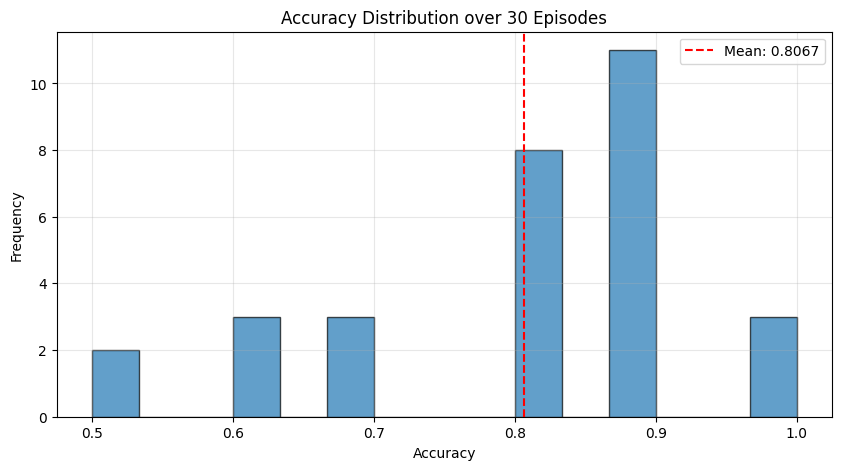

In [70]:
def evaluate_few_shot_model(model, X_test, y_test, n_way=5, k_shot=3, q_query=2, num_episodes=20):
    """
    Evaluate model dengan multiple episodes
    """
    accuracies = []

    for episode in range(num_episodes):
        # Buat episode test
        support_set, query_set, support_labels, query_labels = create_episode(
            X_test, y_test, n_way=n_way, k_shot=k_shot, q_query=q_query
        )

        # Convert to tensors
        support_tensor = tf.convert_to_tensor(support_set, dtype=tf.float32)
        # Cast query_labels_tensor to tf.int64 to match tf.argmax output
        query_tensor = tf.convert_to_tensor(query_set, dtype=tf.float32)
        support_labels_tensor = tf.convert_to_tensor(support_labels, dtype=tf.int32)
        query_labels_tensor = tf.convert_to_tensor(query_labels, dtype=tf.int64)

        # Predict
        logits = model.call(
            support_tensor,
            query_tensor,
            support_labels_tensor,
            n_way
        )

        # Hitung accuracy
        predictions = tf.argmax(logits, axis=1)
        acc = tf.reduce_mean(
            tf.cast(tf.equal(predictions, query_labels_tensor), tf.float32)
        )

        accuracies.append(acc.numpy())

    # Hitung statistik
    mean_acc = np.mean(accuracies)
    std_acc = np.std(accuracies)

    print(f"\nEvaluation over {num_episodes} episodes:")
    print(f"Mean Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    print(f"Min Accuracy: {np.min(accuracies):.4f}")
    print(f"Max Accuracy: {np.max(accuracies):.4f}")

    # Plot distribution
    plt.figure(figsize=(10, 5))
    plt.hist(accuracies, bins=15, alpha=0.7, edgecolor='black')
    plt.axvline(mean_acc, color='red', linestyle='--', label=f'Mean: {mean_acc:.4f}')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    plt.title(f'Accuracy Distribution over {num_episodes} Episodes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return accuracies

# Evaluate model
print("\n" + "="*50)
print("EVALUATION ON TEST SET")
print("="*50)

test_accuracies = evaluate_few_shot_model(
    pn_model,
    X_test,
    y_test,
    n_way=5,
    k_shot=3,
    q_query=2,
    num_episodes=30
)

#### membuat Fungsi dan Memanggil Detect Accent

In [71]:
def detect_accent_from_audio(
    audio_path,
    support_set,
    support_labels,
    n_way,
    metadata_df,
    le_gender_obj,
    le_provinsi_obj,
    scaler_usia_obj,
    ohe_obj
):
    """
    Deteksi aksen 1 audio menggunakan Prototypical Network
    """

    # 1. Ekstraksi fitur audio query (MFCCs only, 3 channels)
    mfcc_feat = extract_mfcc(audio_path)
    if mfcc_feat is None:
        return None, None # Handle error if feature extraction fails

    # 2. Ekstraksi dan proses metadata untuk audio
    file_name = os.path.basename(audio_path)
    row_data = metadata_df[metadata_df['file_name'] == file_name]

    if row_data.empty:
        print(f"Error: Metadata not found for {file_name}")
        return None, None

    usia_val = row_data['usia'].iloc[0]
    gender_val = row_data['gender'].iloc[0]
    provinsi_val = row_data['provinsi'].iloc[0]

    # Scale usia
    usia_scaled_single = scaler_usia_obj.transform(np.array(usia_val).reshape(-1, 1))

    # One-hot encode gender and provinsi
    gender_provinsi_single = np.array([[gender_val, provinsi_val]])
    cat_encoded_single = ohe_obj.transform(gender_provinsi_single)

    # Combine metadata features
    X_meta_single = np.hstack([usia_scaled_single, cat_encoded_single]).astype(np.float32)

    # Broadcast metadata to match MFCC dimensions
    X_meta_single_expanded = X_meta_single[:, np.newaxis, np.newaxis, :]
    X_meta_broadcast_single = np.repeat(X_meta_single_expanded, mfcc_feat.shape[0], axis=1)
    X_meta_broadcast_single = np.repeat(X_meta_broadcast_single, mfcc_feat.shape[1], axis=2)

    # Expand mfcc_feat to add batch dimension
    mfcc_feat_expanded = mfcc_feat[np.newaxis, ...]

    # Concatenate audio features and metadata features along the last axis
    query_features_final = np.concatenate([mfcc_feat_expanded, X_meta_broadcast_single], axis=-1).astype(np.float32)

    # Convert to tensor
    query_tensor = tf.convert_to_tensor(query_features_final, dtype=tf.float32)
    support_tensor = tf.convert_to_tensor(support_set, dtype=tf.float32)
    support_labels_tensor = tf.convert_to_tensor(support_labels, dtype=tf.int32)

    # 3. Forward ke prototypical network
    logits = pn_model.call(
        support_tensor,
        query_tensor,
        support_labels_tensor,
        n_way
    )

    # 4. Memanggil prediksi
    pred_index = tf.argmax(logits, axis=1).numpy()[0]
    pred_label = le_y.inverse_transform([pred_index])[0]

    probs = tf.nn.softmax(logits, axis=1).numpy()[0]

    return pred_label, probs

n_way = 5
k_shot = 3

support_set, _, support_labels, _ = create_episode(
    X_train,
    y_train,
    n_way=n_way,
    k_shot=k_shot,
    q_query=5
)

path = '/content/drive/MyDrive/Voice_Skripsi_fix'

folder_uji = path

for file in os.listdir(folder_uji):
    if file.endswith(".wav"):
        audio_path = os.path.join(folder_uji, file)

        pred, _ = detect_accent_from_audio(
            audio_path,
            support_set,
            support_labels,
            n_way,
            metadata,
            le_gender,
            le_provinsi,
            scaler_usia,
            ohe
        )
        print(file, "→", pred)


Jawa Barat(1).wav → Sunda
Jawa Barat(4).wav → Sunda
Jakarta(9).wav → Betawi
Jawa Tengah(5).wav → Jawa_Tengah
Jawa Tengah(2).wav → Jawa _Timur
Jawa Tengah(8).wav → Betawi
Jawa Tengah(4).wav → Jawa_Tengah
Jawa Tengah(3).wav → Jawa _Timur
Jawa Tengah(6).wav → Jawa_Tengah
Jawa Tengah(11).wav → Jawa_Tengah
Jawa Tengah(10).wav → Jawa _Timur
Jawa Tengah(9).wav → Betawi
YogyaKarta(27).wav → YogyaKarta
YogyaKarta(28).wav → YogyaKarta
Jakarta(6).wav → Jawa_Tengah
Jakarta(4).wav → Betawi
Jakarta(2).wav → Betawi
Jakarta(1).wav → Betawi
Jakarta(43).wav → Betawi
Jakarta(8).wav → Betawi
Jakarta(3).wav → Betawi
Jakarta(7).wav → Betawi
Jawa Barat(33).wav → Sunda
Jakarta(10).wav → Betawi
Jakarta(11).wav → Betawi
Jawa Barat(34).wav → Sunda
Jakarta(12).wav → Betawi
Jakarta(13).wav → Jawa_Tengah
Jawa Barat(35).wav → Sunda
Jakarta(23).wav → Betawi
Jakarta(22).wav → Betawi
Jakarta(15).wav → Betawi
Jakarta(24).wav → Betawi
Jawa Barat(37).wav → Sunda
Jakarta(16).wav → Betawi
Jakarta(26).wav → Betawi
Jakarta(14

# Visualisai

#### Loss Matrix

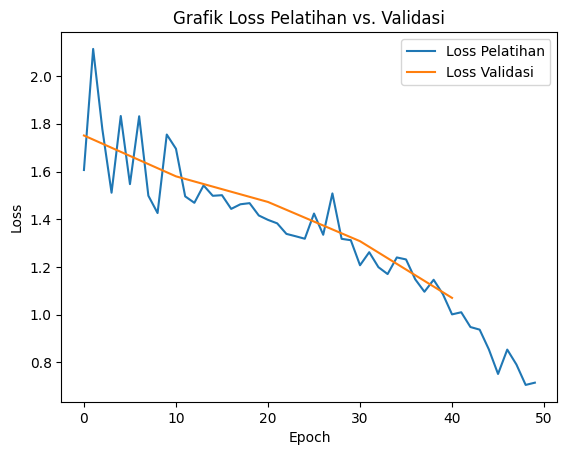

In [72]:
plt.plot(train_losses, label='Loss Pelatihan')
val_epochs = np.arange(0, len(train_losses), 10)
plt.plot(val_epochs, val_losses, label='Loss Validasi')
plt.title('Grafik Loss Pelatihan vs. Validasi')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Distribusi Aksen Setiap Kelas

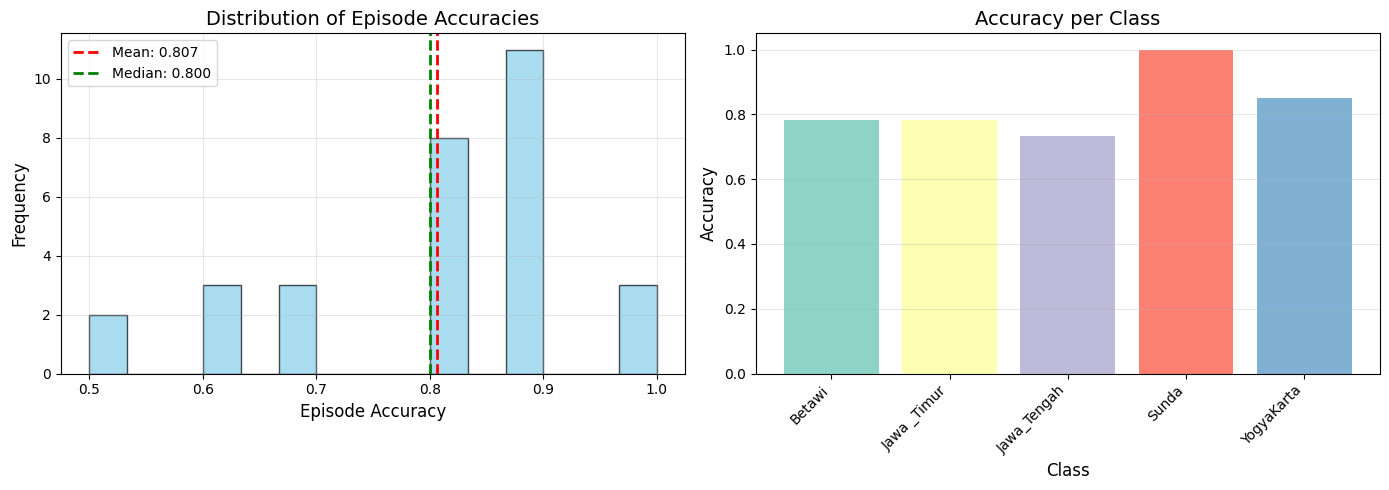

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Use the already calculated test_accuracies
all_episode_accuracies = test_accuracies

# Histogram akurasi
axes[0].hist(all_episode_accuracies, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].axvline(np.mean(all_episode_accuracies), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(all_episode_accuracies):.3f}')
axes[0].axvline(np.median(all_episode_accuracies), color='green', linestyle='--',
                linewidth=2, label=f'Median: {np.median(all_episode_accuracies):.3f}')
axes[0].set_xlabel('Episode Accuracy', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Episode Accuracies', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Collect predictions for (Accuracy per Class)
all_true_labels = []
all_predictions = []
num_episodes_for_class_eval = 30

n_way = 5
k_shot = 3
q_query = 2

for _ in range(num_episodes_for_class_eval):
    support_set_temp, query_set_temp, support_labels_temp, query_labels_temp = create_episode(
        X_test, y_test, n_way=n_way, k_shot=k_shot, q_query=q_query
    )

    support_tensor_temp = tf.convert_to_tensor(support_set_temp, dtype=tf.float32)
    query_tensor_temp = tf.convert_to_tensor(query_set_temp, dtype=tf.float32)
    support_labels_tensor_temp = tf.convert_to_tensor(support_labels_temp, dtype=tf.int32)
    query_labels_tensor_temp = tf.convert_to_tensor(query_labels_temp, dtype=tf.int64)

    logits_temp = pn_model.call(
        support_tensor_temp,
        query_tensor_temp,
        support_labels_tensor_temp,
        n_way
    )
    predictions_temp = tf.argmax(logits_temp, axis=1)

    all_true_labels.extend(query_labels_tensor_temp.numpy())
    all_predictions.extend(predictions_temp.numpy())

all_true_labels = np.array(all_true_labels)
all_predictions = np.array(all_predictions)

# Get class names from the LabelEncoder
class_names = le_y.classes_

# Box plot akurasi per kelas
accuracy_per_class = []
for class_idx in range(n_way):
    mask = (all_true_labels == class_idx)
    if np.sum(mask) > 0:
        class_accuracy = np.mean(all_predictions[mask] == all_true_labels[mask])
        accuracy_per_class.append(class_accuracy)
    else:
        # If a class was not present in query_labels over all episodes
        accuracy_per_class.append(0.0)

axes[1].bar(range(len(accuracy_per_class)), accuracy_per_class,
            color=plt.cm.Set3(np.arange(len(class_names))))
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Accuracy per Class', fontsize=14)
axes[1].set_xticks(range(len(accuracy_per_class)))
axes[1].set_xticklabels(class_names[:len(accuracy_per_class)], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

#### Confusion Matrix

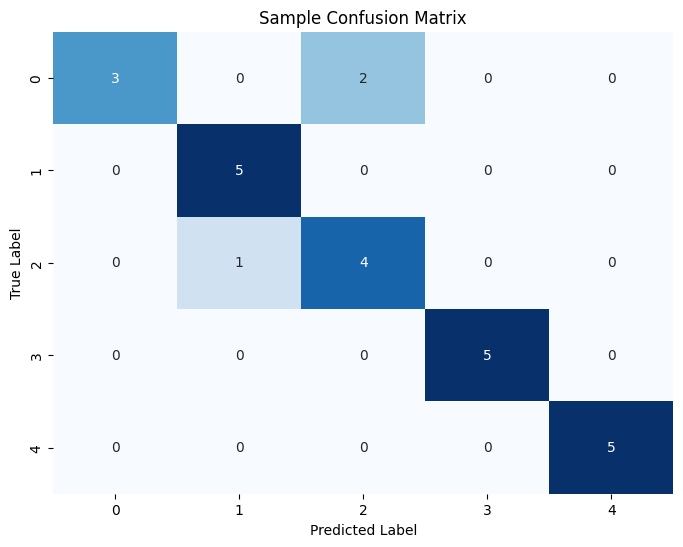

In [74]:
# evaluation parameters for one episode
n_way = 5
k_shot = 3
q_query = 5

support_set_eval, query_set_eval, support_labels_eval, query_labels_eval = create_episode(
    X_test, y_test, n_way=n_way, k_shot=k_shot, q_query=q_query
)

# Convert to tensors
support_tensor_eval = tf.convert_to_tensor(support_set_eval, dtype=tf.float32)
query_tensor_eval = tf.convert_to_tensor(query_set_eval, dtype=tf.float32)
support_labels_tensor_eval = tf.convert_to_tensor(support_labels_eval, dtype=tf.int32)
# Use tf.int64 for query_labels_eval to match tf.argmax output for labels
query_labels_tensor_eval = tf.convert_to_tensor(query_labels_eval, dtype=tf.int64)

# Get logits from the trained prototypical network model
logits_eval = pn_model.call(
    support_tensor_eval,
    query_tensor_eval,
    support_labels_tensor_eval,
    n_way
)

# Get predicted labels
predictions_eval = tf.argmax(logits_eval, axis=1)

# Convert true and predicted labels to numpy arrays for confusion_matrix
y_true = query_labels_tensor_eval.numpy()
y_pred = predictions_eval.numpy()

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Sample Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


#### Representasi Fitur Audio

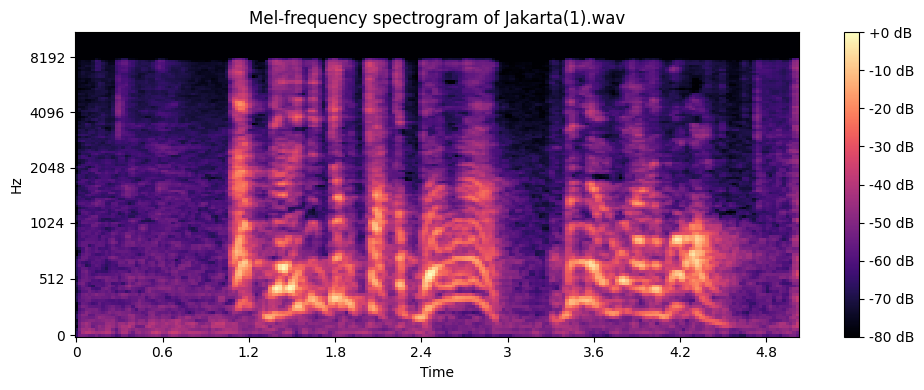

In [75]:
sr = 22050

example_file_name = metadata.loc[0, 'file_name']
example_file_path = os.path.join(path, example_file_name)

y, sr = librosa.load(example_file_path, sr=sr)

S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-frequency spectrogram of {example_file_name}')
plt.tight_layout()
plt.show()

#### Fitur MFCC

In [ ]:
unique_classes = np.unique(y_aksen)
sample_indices = []

for cls in unique_classes:
    # Cari indeks pertama untuk kelas ini
    idx = np.where(y_aksen == cls)[0][0]
    sample_indices.append(idx)

    print(f"Kelas {le_y.classes_[cls]} - Sampel index: {idx}")

print("\n" + "="*50)

# Visualisasi untuk 5 sampel berbeda (mewakili 5 kelas)
fig, axes = plt.subplots(5, 3, figsize=(15, 12))

for i, sample_idx in enumerate(sample_indices):
    # Ambil label kelas
    label = le_y.classes_[y_aksen[sample_idx]]

    # MFCC Original
    axes[i, 0].imshow(X_audio_features[sample_idx, :, :, 0],
                      aspect='auto', cmap='coolwarm')
    if i == 0:
        axes[i, 0].set_title('MFCC Original')

    # Delta MFCC
    axes[i, 1].imshow(X_audio_features[sample_idx, :, :, 1],
                      aspect='auto', cmap='viridis')
    if i == 0:
        axes[i, 1].set_title('Delta MFCC')

    # Delta-Delta MFCC
    axes[i, 2].imshow(X_audio_features[sample_idx, :, :, 2],
                      aspect='auto', cmap='plasma')
    if i == 0:
        axes[i, 2].set_title('Delta-Delta MFCC')

    # Set label di kiri
    axes[i, 0].set_ylabel(f'Kelas: {label}\nKoefisien MFCC', fontsize=10)

# Set label untuk sumbu x hanya di baris terakhir
for j in range(3):
    axes[4, j].set_xlabel('Frame Waktu')

plt.suptitle('Perbandingan Fitur MFCC untuk 5 Kelas Aksen yang Berbeda',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

Kelas Betawi - Sampel index: 0
Kelas Jawa _Timur - Sampel index: 180
Kelas Jawa_Tengah - Sampel index: 120
Kelas Sunda - Sampel index: 60
Kelas YogyaKarta - Sampel index: 240



#### TSNE

In [ ]:
from sklearn.manifold import TSNE

num_samples = min(100, len(X_test))
random_indices = np.random.choice(len(X_test), num_samples, replace=False)

# Ekstrak embedding
embeddings = []
labels = []

for idx in random_indices:
    # Get embedding dari model
    sample_tensor = tf.convert_to_tensor(X_test[idx:idx+1], dtype=tf.float32)
    embedding = pn_model.embedding(sample_tensor).numpy()[0]
    embeddings.append(embedding)
    labels.append(y_test[idx])

# Konversi ke numpy array
embeddings = np.array(embeddings)
labels = np.array(labels)

# Reduksi dimensi dengan t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot hasil t-SNE
plt.figure(figsize=(10, 8))


for class_label in np.unique(labels):
    idx = labels == class_label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1],
                label=le_y.classes_[class_label],
                alpha=0.6, s=50)

plt.title('Visualisasi Embedding Space dengan t-SNE', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Kelas Aksen')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print informasi
print(f"Shape embedding asli: {embeddings.shape}")
print(f"Shape setelah t-SNE: {embeddings_2d.shape}")
print(f"Jumlah sampel: {num_samples}")
print(f"Jumlah kelas: {len(np.unique(labels))}")

In [ ]:

"""#### Confusiion Matrix"""


"""#### Visualisasi representasi fitur Audio"""



import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np

sr = 22050

# Define path and load metadata explicitly to avoid NameError
path = '/content/drive/MyDrive/Voice_Skripsi_fix'
csv_path = os.path.join(path, 'metadata.csv')
metadata = pd.read_csv(csv_path)

# Find a sample file for 'Sunda' accent (representing Jawa Barat)
sunda_file_name = metadata[metadata['label_aksen'] == 'Sunda']['file_name'].iloc[0]
sunda_file_path = os.path.join(path, sunda_file_name)

y, sr = librosa.load(sunda_file_path, sr=sr)

# Compute Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-frequency spectrogram for Sundanese (Jawa Barat) accent: {sunda_file_name}')
plt.tight_layout()
plt.show()

import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np

sr = 22050

# Define path and load metadata explicitly to avoid NameError
path = '/content/drive/MyDrive/Voice_Skripsi_fix'
csv_path = os.path.join(path, 'metadata.csv')
metadata = pd.read_csv(csv_path)

# Find a sample file for 'Jawa _Timur' accent
jatim_file_name = metadata[metadata['label_aksen'] == 'Jawa _Timur']['file_name'].iloc[0]
jatim_file_path = os.path.join(path, jatim_file_name)

y, sr = librosa.load(jatim_file_path, sr=sr)

# Compute Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-frequency spectrogram for Jatim (Jawa Timur) accent: {jatim_file_name}')
plt.tight_layout()
plt.show()

import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np

sr = 22050

# Define path and load metadata explicitly to avoid NameError
path = '/content/drive/MyDrive/Voice_Skripsi_fix'
csv_path = os.path.join(path, 'metadata.csv')
metadata = pd.read_csv(csv_path)

# Find a sample file for 'Jawa_Tengah' accent
jateng_file_name = metadata[metadata['label_aksen'] == 'Jawa_Tengah']['file_name'].iloc[0]
jateng_file_path = os.path.join(path, jateng_file_name)

y, sr = librosa.load(jateng_file_path, sr=sr)

# Compute Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-frequency spectrogram for Jateng (Jawa Tengah) accent: {jateng_file_name}')
plt.tight_layout()
plt.show()

import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np

sr = 22050

# Define path and load metadata explicitly to avoid NameError
path = '/content/drive/MyDrive/Voice_Skripsi_fix'
csv_path = os.path.join(path, 'metadata.csv')
metadata = pd.read_csv(csv_path)

# Find a sample file for 'YogyaKarta' accent
yogyakarta_file_name = metadata[metadata['label_aksen'] == 'YogyaKarta']['file_name'].iloc[0]
yogyakarta_file_path = os.path.join(path, yogyakarta_file_name)

y, sr = librosa.load(yogyakarta_file_path, sr=sr)

# Compute Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-frequency spectrogram for Yogyakarta accent: {yogyakarta_file_name}')
plt.tight_layout()
plt.show()

import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np

sr = 22050

# Define path and load metadata explicitly to avoid NameError
path = '/content/drive/MyDrive/Voice_Skripsi_fix'
csv_path = os.path.join(path, 'metadata.csv')
metadata = pd.read_csv(csv_path)

# Find a sample file for 'Jawa _Timur' accent (corrected label)
jawa_timur_file_name = metadata[metadata['label_aksen'] == 'Jawa _Timur']['file_name'].iloc[0]
jawa_timur_file_path = os.path.join(path, jawa_timur_file_name)

y, sr = librosa.load(jawa_timur_file_path, sr=sr) # Use jawa_timur_file_path here

# Compute Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Mel-frequency spectrogram for Jatim (Jawa Timur) accent: {jawa_timur_file_name}')
plt.tight_layout()
plt.show()

"""#### Visualisasi Fitur MFCC yang diEkstrasi"""

unique_classes = np.unique(y_aksen)
sample_indices = []

for cls in unique_classes:
    # Cari indeks pertama untuk kelas ini
    idx = np.where(y_aksen == cls)[0][0]
    sample_indices.append(idx)

    print(f"Kelas {le_y.classes_[cls]} - Sampel index: {idx}")

print("\n" + "="*50)

# Visualisasi untuk 5 sampel berbeda (mewakili 5 kelas)
fig, axes = plt.subplots(5, 3, figsize=(15, 12))

for i, sample_idx in enumerate(sample_indices):
    # Ambil label kelas
    label = le_y.classes_[y_aksen[sample_idx]]

    # MFCC Original
    axes[i, 0].imshow(X_audio_features[sample_idx, :, :, 0],
                      aspect='auto', cmap='coolwarm')
    if i == 0:
        axes[i, 0].set_title('MFCC Original')

    # Delta MFCC
    axes[i, 1].imshow(X_audio_features[sample_idx, :, :, 1],
                      aspect='auto', cmap='viridis')
    if i == 0:
        axes[i, 1].set_title('Delta MFCC')

    # Delta-Delta MFCC
    axes[i, 2].imshow(X_audio_features[sample_idx, :, :, 2],
                      aspect='auto', cmap='plasma')
    if i == 0:
        axes[i, 2].set_title('Delta-Delta MFCC')

    # Set label di kiri
    axes[i, 0].set_ylabel(f'Kelas: {label}\nKoefisien MFCC', fontsize=10)

# Set label untuk sumbu x hanya di baris terakhir
for j in range(3):
    axes[4, j].set_xlabel('Frame Waktu')

plt.suptitle('Perbandingan Fitur MFCC untuk 5 Kelas Aksen yang Berbeda',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

"""#### Visualisasi embedding space"""

